# Group4 AML Challenge 1 Notebook

General thoughts: (Thoughts that are not yet assigned to a section)
- Model validation:
    - Dataset is probably too large for k-fold-cross-validation (Philipp)
    - We should put some regions only in the validation set and not the training set to have a good indicator on generalization performance. (Philipp)
- Performance:
    - We can quickly try out models with a small proxy subset (Philipp)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eurecom-aml-2022-challenge-1/example_preds.csv
/kaggle/input/eurecom-aml-2022-challenge-1/public/train.csv
/kaggle/input/eurecom-aml-2022-challenge-1/public/test_feat.csv


In [2]:
# Load data
df = pd.read_csv('../input/eurecom-aml-2022-challenge-1/public/train.csv',low_memory = True)

In [3]:
# Create smaller proxy subsets 'df_small_[magnitude]' with 10^magnitude samples
for mag in [3, 4, 5]:
    name = f'df_small_{mag}'
    globals()[name] = df.sample(n=10**mag, random_state=1, ignore_index=True)
    globals()[name].to_csv('df_small.csv')

# Data analysis
The purpose of the section is to explore the data:
- Get insight into the data
- Find potential problems for models
- Find biases in the data

Specific tasks/questions we want to answer:
- Samples from how many different locations?
- Do we have outliers and in which features?
- How many 'null' values are there and in which features?

Given description:\
"\
In this challenge, you are free (and encouraged) to explore in depth the data you have, you can run simple queries on the data, perform exploration and compute statistics.

**NOTE**: finding the right question to ask is difficult! Don't be afraid to complement your analysis with your own questions. This can give you extra points!

**NOTE 2**: the presentation quality is critical in any business-oriented data analysis. Take time to create few but informative plots, rather than endless tables!\
"

### General Properties of the Data
Motivation: Obvious

Results:
- ...

In [4]:
df.describe()

,index,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,...,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next,fact_temperature
count,1.993574e+06,1.993574e+06,1.993574e+06,1.993574e+06,1.993574e+06,1.993574e+06,1.993574e+06,1.993574e+06,1.991773e+06,1.991773e+06,...,1.991773e+06,1.991773e+06,1.991773e+06,1.991773e+06,1.991773e+06,1.993574e+06,1.993574e+06,1.993574e+06,1.993574e+06,1.993574e+06
mean,9.967865e+05,1.543582e+09,3.115462e+01,-2.703852e+01,3.285789e+02,-5.860210e+00,1.351736e+01,7.302612e+02,2.797381e+02,7.695832e+00,...,3.325517e-01,2.381313e-03,3.807693e-02,7.312622e-04,1.097395e-02,6.764290e-03,6.311309e+00,1.549980e-03,1.965856e+01,1.331723e+01
std,5.754954e+05,4.515794e+06,2.088655e+01,7.436018e+01,5.194110e+02,3.672498e+01,8.723483e+00,4.484426e+01,9.535258e+00,5.933824e+00,...,1.995224e+00,7.590582e-02,4.962380e-01,4.491461e-02,2.661001e-01,1.509631e+00,9.470227e+00,1.797734e+01,3.335334e+01,1.000971e+01
min,0.000000e+00,1.535760e+09,-6.760167e+01,-1.663390e+02,-2.126000e+03,-8.989978e+01,-2.721357e+01,4.072077e+02,2.249846e+02,0.000000e+00,...,0.000000e+00,-5.000000e-06,0.000000e+00,-5.000000e-06,0.000000e+00,-3.999998e+01,-6.865307e+01,-1.000000e+02,0.000000e+00,-4.500000e+01
25%,4.983932e+05,1.539669e+09,3.006920e+01,-9.114960e+01,2.300000e+01,-3.667559e+01,7.025714e+00,7.225525e+02,2.735037e+02,3.250000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.218262e-01,-4.999390e-02,0.000000e+00,0.000000e+00,6.000000e+00
50%,9.967865e+05,1.543582e+09,3.566000e+01,-1.721460e+01,1.160000e+02,-2.911450e+00,1.320000e+01,7.482880e+02,2.798528e+02,6.375000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.150018e+00,0.000000e+00,0.000000e+00,1.300000e+01
75%,1.495180e+06,1.547491e+09,4.153240e+01,2.461920e+01,3.910000e+02,2.422460e+01,2.000857e+01,7.584323e+02,2.866298e+02,1.050000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.787109e-01,1.315002e+01,0.000000e+00,2.700000e+01,2.100000e+01
max,1.993573e+06,1.551395e+09,7.093306e+01,1.753880e+02,4.659000e+03,8.986517e+01,4.599286e+01,8.051014e+02,3.028238e+02,3.062500e+01,...,1.151527e+02,1.585967e+01,3.725895e+01,1.298353e+01,3.961083e+01,5.190001e+01,2.924999e+01,1.000000e+02,1.000000e+02,6.000000e+01


### Relation between temperature and cloud coverage
Motivation: ... (short ;))

Results: ... (What do you read from the plot?)

In [5]:
df = df.sort_values('fact_longitude').where(df.fact_longitude<-140)

In [6]:
import matplotlib.pyplot as plt
import torch

#once you are on a segment of longitudes, make a df that is sorted in fct of the column or the temp to get line plots that are more sensible

def plot_tempeturs_in_function_of(column, increments):#good to have the longitude 360 divisible by the increment
    idx = 0
    plt.figure(figsize=(8, 6), dpi=80)
    for longitude in range(-180,181):
        base_longitude = longitude
        Y = []
        X = []
        while(np.float64(df.fact_longitude[idx:idx+1])<base_longitude + increments):
            Y.append(np.float64(df.fact_temperature[idx:idx+1]))
            X.append(np.float64(df[column][idx:idx+1]))
            idx += 1
        # plot point clouds 

        #plt.plot(X, Y)#, label = f"longitude [{str(base_longitude)};{str(base_longitude + increments)}]")
        plt.scatter(X,Y)
        plt.legend()
        plt.title(f"tempeturs_in_function_of_{str(column)}")
        plt.xlabel(column)
        plt.ylabel("fact_temperature")
    plt.show()

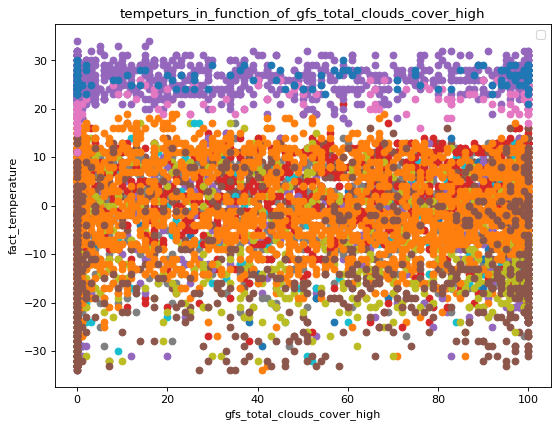

In [7]:
plot_tempeturs_in_function_of('gfs_total_clouds_cover_high',10)

So we have data for about 150 000 datapoints for each of 8000 different locations.

In [8]:
print('Number of unique locations : ',len(df[['fact_latitude','fact_longitude']].drop_duplicates()))
print('Number of time points : ',len(df['fact_time'].drop_duplicates()))

Number of unique locations :  29
Number of time points :  10382


This shows that the majority of our temperature points are between 0 and 30 C, with a few strange outliers. Is t = 60 C real??

<AxesSubplot:>

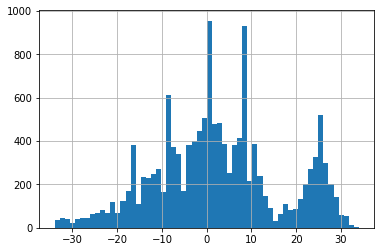

In [9]:
temps = df['fact_temperature']
temps.hist(bins=60)

### Show samples on map
Motivation: See how dense the samples are in the different areas in the training and test data. This helps to see where problems might arise when training the model.

Results: [in progress]

In [10]:
# Get all measure stations
df_data_points = df[['fact_latitude','fact_longitude']].drop_duplicates()
# Drop all columns except from lat and long
df_data_points.drop(df_data_points.columns.difference(['fact_latitude','fact_longitude']), axis=1, inplace=True)

# TODO: Create dataframe with number of data points per measure station
# TODO: Add test data to map and color depending on number of data points per measure station

In [11]:
# Library reference for this code: https://plotly.com/python/mapbox-layers/
import plotly.express as px

fig = px.scatter_mapbox(df_data_points, lat="fact_latitude", lon="fact_longitude", hover_data=["fact_latitude", "fact_longitude"],
                        color_discrete_sequence=["fuchsia"], zoom=1, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Data Pre-processing/Feature Engineering
In this section we process the data by doing for example the following things:
-    Normalising and standardising the given data;
-    Removing outliers;
-    Carrying out feature selection, possibly using metrics derived from information theory;
-    Handling missing information in the dataset;
-    Augmenting the dataset with external information;
-    Combining existing features.

# Model Selection

Perhaps one of the most important segments of this challenge involves the selection of a model that can successfully handle the given data and yield sensible predictions. Instead of focusing exclusively on your final chosen model, it is also important to share your thought process in this notebook by additionally describing alternative candidate models. There is a wealth of models to choose from, such as decision trees, random forests, (Bayesian) neural networks, Gaussian processes, Lasso regression, and so on. There are several factors which may influence your decision:

-    What is the model's complexity?
-    Is the model interpretable?
-    Is the model capable of handling different data-types?
-    Does the model return uncertainty estimates along with predictions?

(In this baseline solution, we use the Lasso regression model, which is a linear least-square model with L1 regularization on its parameters. There is a hyper-parameter that should be tuned which is the regularization strength α. Intuitively, this hyper-parameter controls the amount of shrinkage of the parameters of the model: the larger the value of α the greater the amount of shrinkage.\
Section 3.4.1 of the book The Elements of Statistical Learning: Data Mining, Inference, and Prediction from Trevor Hastie et al. (link) is a good reference for some classic regression models.)

# Parameter Optimisation

Irrespective of your choice, it is highly likely that your model will have one or more parameters that require tuning. There are several techniques for carrying out such a procedure, including cross-validation, Bayesian optimisation, and several others. As before, an analysis into which parameter tuning technique best suits your model is expected before proceeding with the optimisation of your model.

# Model Evaluation

Some form of pre-evaluation will inevitably be required in the preceding sections in order to both select an appropriate model and configure its parameters appropriately. In this final section, you may evaluate other aspects of the model such as:

-    Assessing the running time of your model;
-    Determining whether some aspects can be parallelised;
-    Training the model with smaller subsets of the data.
-    etc.

Remember, the goal of this challenge is to construct a model for predicting the temperature around the globe.


# Submission